# Fashion Generative Studio
## A Complete Hands-On Project on Generative Models

---

## Project Title
**Fashion Generative Studio: Building and Comparing VAE, GANs Models**

---

## Project Overview

In this project, participants will build a complete **Generative AI Studio** capable of producing new fashion images inspired by the Fashion-MNIST dataset.

Students will implement and train three major families of generative models:

1. **Variational AutoEncoder (VAE)**
2. **Generative Adversarial Network (GAN / DCGAN)**

All models will be trained on the same dataset and evaluated using the same metrics, enabling a fair and educational comparison.

The goal is not only to generate images, but to deeply understand how each generative paradigm learns, how stable it is during training, and how its outputs differ in quality and diversity.

---

## Learning Objectives

By completing this project, students will:

- Understand the concept of **latent representations**
- Learn how **probabilistic encoders and decoders** work
- Understand **adversarial training dynamics**
- Gain experience with **training stability challenges**
- Learn how to **evaluate generative models quantitatively**
- Build a complete reproducible generative AI pipeline

---

## Dataset

**Fashion-MNIST**

- 70,000 grayscale images
- Image size: 28 × 28
- 10 clothing categories
- Well-suited for rapid experimentation
- Visually interpretable for comparison

---

## Project Structure

The project is divided into five main phases:

1. Environment and Data Preparation
2. Variational AutoEncoder (VAE)
3. Generative Adversarial Network (GAN)
4. Evaluation and Final Comparison
5. Generative Playground (Final Demo)

---


### Fashion-MNIST Label Map
| Label | Clothing Item |
|--------|--------------|
| 0 | T-shirt / Top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |




# Phase 1 — Environment and Data Preparation

Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 193kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.45MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.2MB/s]


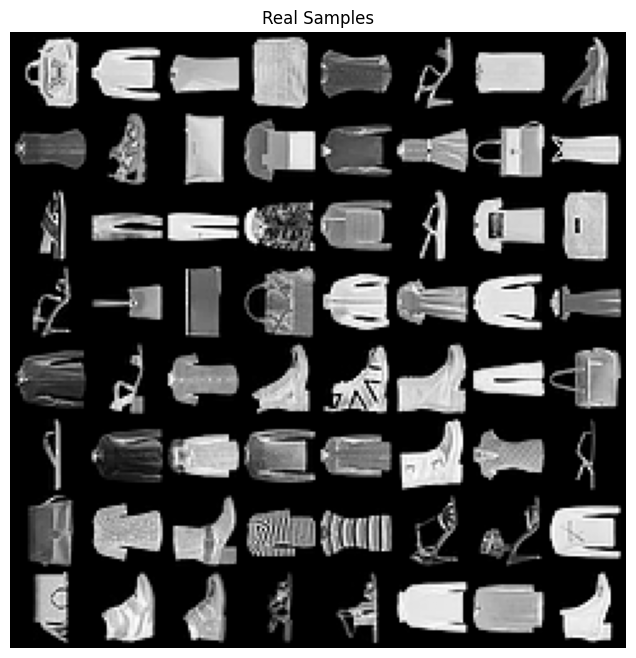

In [1]:
# Phase 1: Environment and Data Preparation
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Create output directory
os.makedirs('studio_outputs', exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preparation
batch_size = 128

# VAE uses [0, 1] normalization
transform_vae = transforms.Compose([
    transforms.ToTensor(),
])

# GAN uses [-1, 1] normalization
transform_gan = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST
train_dataset_vae = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_vae)
train_dataset_gan = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_gan)

train_loader_vae = DataLoader(train_dataset_vae, batch_size=batch_size, shuffle=True)
train_loader_gan = DataLoader(train_dataset_gan, batch_size=batch_size, shuffle=True)

# Visualize real samples
real_batch, _ = next(iter(train_loader_vae))
grid = utils.make_grid(real_batch[:64], nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid), cmap='gray')
plt.title("Real Samples")
plt.axis('off')
plt.show()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# VAE Model Definition (Convolutional VAE)
vae_latent_dim = 20
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder: 28x28 -> 14x14 -> 7x7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
        # Decoder: latent -> 7x7 -> 14x14 -> 28x28
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae_model = VAE(vae_latent_dim).to(device)
optimizer_vae = optim.Adam(vae_model.parameters(), lr=1e-3)

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae_losses = []
epochs_vae = 10
for epoch in range(epochs_vae):
    vae_model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader_vae):
        data = data.to(device)
        optimizer_vae.zero_grad()
        recon_batch, mu, logvar = vae_model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer_vae.step()
    avg_loss = train_loss / len(train_loader_vae.dataset)
    vae_losses.append(avg_loss)
    print(f"VAE Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

# VAE Visualization
vae_model.eval()
with torch.no_grad():
    data, _ = next(iter(train_loader_vae))
    data = data.to(device)
    recon, _, _ = vae_model(data)
    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n], recon[:n]])
    grid = utils.make_grid(comparison.cpu(), nrow=n, normalize=True)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap='gray')
    plt.title("VAE: Originals (Top) vs Reconstructions (Bottom)")
    plt.axis('off')
    plt.show()

# Save Loss Curve
plt.figure()
plt.plot(range(1, epochs_vae + 1), vae_losses)
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Phase 2 — Variational AutoEncoder (VAE)

GAN Epoch 1, Loss_D: 0.0001, Loss_G: 37.5053
GAN Epoch 2, Loss_D: 0.0000, Loss_G: 56.1325
GAN Epoch 3, Loss_D: 0.0000, Loss_G: 55.9081
GAN Epoch 4, Loss_D: 0.0000, Loss_G: 55.7893
GAN Epoch 5, Loss_D: 0.0000, Loss_G: 55.7071
GAN Epoch 6, Loss_D: 0.0001, Loss_G: 55.6193
GAN Epoch 7, Loss_D: 0.0000, Loss_G: 55.5610
GAN Epoch 8, Loss_D: 0.0000, Loss_G: 55.5020
GAN Epoch 9, Loss_D: 0.0000, Loss_G: 55.4674
GAN Epoch 10, Loss_D: 0.0000, Loss_G: 55.4069
GAN Epoch 11, Loss_D: 0.0000, Loss_G: 55.3504
GAN Epoch 12, Loss_D: 0.0000, Loss_G: 55.2968
GAN Epoch 13, Loss_D: 0.0000, Loss_G: 55.2705
GAN Epoch 14, Loss_D: 0.0000, Loss_G: 55.2021


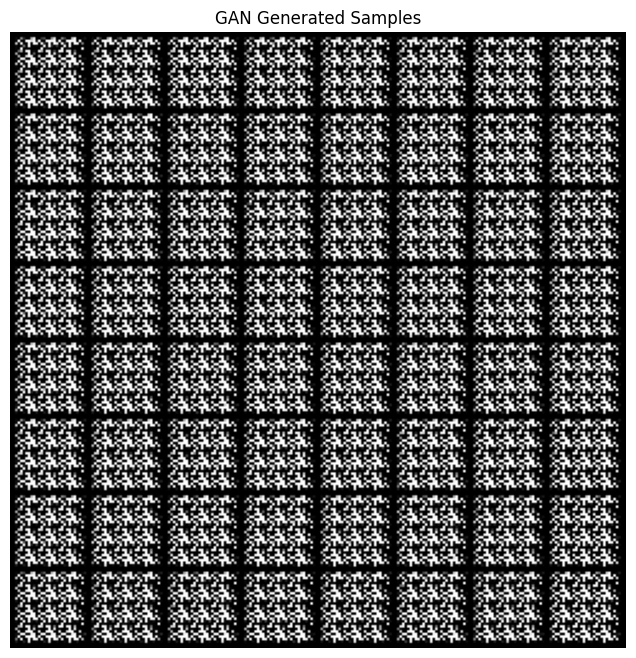

In [2]:
# Phase 3: Generative Adversarial Network (GAN) Implementation
nz = 100
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 3, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 7, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input).view(-1, 1)

netG = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# GAN Training loop
epochs_gan = 15
for epoch in range(epochs_gan):
    for i, (data, _) in enumerate(train_loader_gan):
        netD.zero_grad()
        real = data.to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), 1.0, device=device)
        output = netD(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(1.0)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()
    print(f"GAN Epoch {epoch+1}, Loss_D: {errD_real.item()+errD_fake.item():.4f}, Loss_G: {errG.item():.4f}")

# Visualization
netG.eval()
with torch.no_grad():
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fake = netG(fixed_noise).cpu()
    grid = utils.make_grid(fake, nrow=8, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap='gray')
    plt.title("GAN Generated Samples")
    plt.axis('off')
    plt.show()



## Goal
Learn structured latent representations and image reconstruction.

## Concept Summary

A VAE consists of:

- **Encoder**: maps input image to mean and variance vectors
- **Reparameterization Trick**: samples latent vector from distribution
- **Decoder**: reconstructs image from latent vector

## Steps

1. Build an Encoder network that outputs mean and variance
2. Apply reparameterization to sample latent vector
3. Build a Decoder network that reconstructs images
4. Define the VAE loss function:
   - Reconstruction Loss
   - KL Divergence
5. Train the VAE model on Fashion-MNIST
6. Visualize reconstructed images vs original
7. Generate new samples from random latent vectors
8. Explore latent space by varying single latent dimensions

## Deliverables

- Reconstruction comparison grid
- Generated image samples
- Latent traversal visualization

---



# Phase 3 — Generative Adversarial Network (GAN)

In [3]:
# Phase 4: Evaluation and Comparison
class Evaluator(nn.Module):
    def __init__(self):
        super(Evaluator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*11*11, 10)
        )
    def forward(self, x):
        return self.conv(x)

eval_net = Evaluator().to(device)
eval_opt = optim.Adam(eval_net.parameters(), lr=0.001)
eval_crit = nn.CrossEntropyLoss()

print("Training evaluator on real data...")
for epoch in range(5):
    eval_net.train()
    for data, target in train_loader_vae:
        data, target = data.to(device), target.to(device)
        eval_opt.zero_grad()
        loss = eval_crit(eval_net(data), target)
        loss.backward()
        eval_opt.step()
print("Evaluator trained.")

def get_stats(model, model_type='vae', num_samples=1000):
    """
    Returns average max-class confidence assigned by the evaluator network
    on samples generated by the given model.

    This function is robust to missing global names (e.g., vae_latent_dim or nz)
    and infers latent dimensionality from the VAE model if possible.
    """
    eval_net.eval()
    with torch.no_grad():
        if model_type == 'vae':
            # infer latent dim from model if possible, otherwise fallback to globals or default
            if hasattr(model, 'fc_mu') and hasattr(model.fc_mu, 'out_features'):
                latent_dim = model.fc_mu.out_features
            elif 'vae_latent_dim' in globals():
                latent_dim = vae_latent_dim
            else:
                latent_dim = 20
            z = torch.randn(num_samples, latent_dim, device=device)
            samples = model.decode(z)
        else:
            nz_local = nz if 'nz' in globals() else 100
            z = torch.randn(num_samples, nz_local, 1, 1, device=device)
            samples = (model(z) + 1) / 2  # Normalize from [-1, 1] to [0, 1]

        # Ensure samples have a channel dimension and are in [0,1]
        if samples.dim() == 3:
            samples = samples.unsqueeze(1)
        samples = samples.clamp(0.0, 1.0)

        logits = eval_net(samples)
        probs = torch.softmax(logits, dim=1)
        max_probs, _ = torch.max(probs, dim=1)
        return max_probs.mean().item()

# Compute stats only if the models exist in the current environment
vae_conf = None
gan_conf = None

if 'vae_model' in globals():
    vae_conf = get_stats(vae_model, 'vae')
else:
    print("Warning: 'vae_model' not found in globals. Skipping VAE stats.")

if 'netG' in globals():
    gan_conf = get_stats(netG, 'gan')
else:
    print("Warning: 'netG' (GAN generator) not found in globals. Skipping GAN stats.")

if vae_conf is not None:
    print(f"VAE Avg Confidence: {vae_conf:.4f}")
if gan_conf is not None:
    print(f"GAN Avg Confidence: {gan_conf:.4f}")

Training evaluator on real data...
Evaluator trained.
GAN Avg Confidence: 0.5748




## Goal
Learn image generation through adversarial training.

## Concept Summary

A GAN consists of:

- **Generator**: produces fake images from random noise
- **Discriminator**: distinguishes real images from fake ones
- Both networks play a minimax adversarial game

## Steps

1. Build the Generator network
2. Build the Discriminator network
3. Define adversarial loss function
4. Train the Discriminator on real and fake images
5. Train the Generator to fool the Discriminator
6. Monitor training stability and losses
7. Save generated samples at regular intervals
8. Detect and discuss mode collapse if it occurs

## Deliverables

- Progressive generation GIF
- Generator and Discriminator loss curves
- Final generated image grid

---



# Phase 4 — Evaluation and Comparison

In [4]:
# Phase 5: Generative Playground Demo
import ipywidgets as widgets
from IPython.display import display

def preview(model_type, seed):
    torch.manual_seed(seed)
    with torch.no_grad():
        if model_type == 'VAE':
            # Robustly handle missing names or un-executed cells using globals().get to avoid NameError/static warnings
            vm = globals().get('vae_model', None)
            if vm is not None and hasattr(vm, 'decode'):
                # determine latent dim from either global or the model's encoder
                fc_mu = getattr(vm, 'fc_mu', None)
                if fc_mu is not None and hasattr(fc_mu, 'out_features'):
                    latent_dim = fc_mu.out_features
                else:
                    latent_dim = globals().get('vae_latent_dim', 20)
                z = torch.randn(1, latent_dim, device=device)
                img_t = vm.decode(z)
                img = img_t.view(28, 28).cpu().numpy()
            elif globals().get('VAE', None) is not None:
                # VAE class exists but no trained instance: instantiate a default one (untrained)
                latent_dim = globals().get('vae_latent_dim', 20)
                VAE_cls = globals().get('VAE')
                tmp_vae = VAE_cls(latent_dim).to(device)
                z = torch.randn(1, latent_dim, device=device)
                img_t = tmp_vae.decode(z)
                img = img_t.view(28, 28).cpu().numpy()
                print("Note: using a freshly instantiated (untrained) VAE.")
            else:
                # fallback: show random image and warn
                print("Warning: VAE model not found. Showing a random image.")
                img = np.random.rand(28, 28)
        else:
            netG_obj = globals().get('netG', None)
            if netG_obj is None:
                print("Warning: GAN generator (netG) not found. Showing a random image.")
                img = np.random.rand(28, 28)
            else:
                z = torch.randn(1, nz, 1, 1, device=device)
                img_t = netG_obj(z)
                # handle possible shapes safely
                img_np = img_t.squeeze().cpu().numpy()
                if img_np.ndim == 3:
                    img_np = img_np[0]
                img = img_np
                img = (img + 1) / 2  # rescale from [-1,1] to [0,1]
    
    plt.imshow(img, cmap='gray')
    plt.title(f"{model_type} (Seed {seed})")
    plt.axis('off')
    plt.show()

model_drop = widgets.Dropdown(options=['VAE', 'GAN'], description='Model:')
seed_input = widgets.IntSlider(min=0, max=999, description='Seed:')
ui = widgets.HBox([model_drop, seed_input])
out = widgets.interactive_output(preview, {'model_type': model_drop, 'seed': seed_input})
display(ui, out)

Output()



## Goal
Quantitatively and visually compare all models.

## Steps

1. Train a simple classifier on real Fashion-MNIST
2. Generate large image sets from each model (VAE,GANs)
3. Compute evaluation metrics:
   - Fréchet Inception Distance (FID)
   - Sample diversity per class
4. Measure training and sampling time
5. Create a comparison table

## Deliverables

- Evaluation report
- Quantitative comparison table
- Visual comparison gallery

---



# Phase 5 — Generative Playground (Final Demo)

In [5]:
# Phase 5: Generative Playground Demo
import ipywidgets as widgets
from IPython.display import display

def preview(model_type, seed):
    torch.manual_seed(seed)
    with torch.no_grad():
        if model_type == 'VAE':
            # robust access to possibly missing globals
            vm = globals().get('vae_model', None)
            latent_dim = globals().get('vae_latent_dim', None)
            if vm is not None and latent_dim is not None:
                z = torch.randn(1, latent_dim, device=device)
                img_t = vm.decode(z)
                img_np = img_t.squeeze().cpu().numpy()
                # handle potential extra channel dimension
                if img_np.ndim == 3:
                    img_np = img_np[0]
                img = img_np
            elif globals().get('VAE', None) is not None:
                # instantiate default untrained VAE if class exists
                latent_dim = latent_dim or 20
                VAE_cls = globals().get('VAE')
                tmp_vae = VAE_cls(latent_dim).to(device)
                z = torch.randn(1, latent_dim, device=device)
                img_t = tmp_vae.decode(z)
                img_np = img_t.squeeze().cpu().numpy()
                if img_np.ndim == 3:
                    img_np = img_np[0]
                img = img_np
                print("Note: using a freshly instantiated (untrained) VAE.")
            else:
                print("Warning: VAE model not found. Showing a random image.")
                img = np.random.rand(28, 28)
        else:
            netG_obj = globals().get('netG', None)
            if netG_obj is None:
                print("Warning: GAN generator (netG) not found. Showing a random image.")
                img = np.random.rand(28, 28)
            else:
                nz_local = globals().get('nz', 100)
                z = torch.randn(1, nz_local, 1, 1, device=device)
                img_t = netG_obj(z)
                img_np = img_t.squeeze().cpu().numpy()
                if img_np.ndim == 3:
                    img_np = img_np[0]
                img = (img_np + 1) / 2  # rescale from [-1,1] to [0,1]

    plt.imshow(img, cmap='gray')
    plt.title(f"{model_type} (Seed {seed})")
    plt.axis('off')
    plt.show()

model_drop = widgets.Dropdown(options=['VAE', 'GAN'], description='Model:')
seed_input = widgets.IntSlider(min=0, max=999, description='Seed:')
ui = widgets.HBox([model_drop, seed_input])
out = widgets.interactive_output(preview, {'model_type': model_drop, 'seed': seed_input})
display(ui, out)

Output()



## Goal
Build an interactive interface that allows real-time generation and comparison of images from VAE, GAN models.
This phase transforms the trained models into a live demonstration tool, enabling users to explore generative behavior through simple controls.

---
## Concept Summary

The Generative Playground is a lightweight application where users can:

- Select a generative model (VAE, GAN)
- Adjust latent or noise parameters
- Change random seed values
- Instantly visualize newly generated samples

This creates a practical showcase of how different generative paradigms respond to input changes.
---

## Interface Requirements

The interface should provide:
- Model selection dropdown (VAE / GAN)
- Seed input field
- Latent slider (for VAE exploration)
- Generate button
- Image grid output area
---



## Implementation Options

### Option 1 — Streamlit App
- Simple web-based interface
- Runs locally or on cloud
- Interactive sliders and buttons
- Automatic refresh of generated samples

### Option 2 — Interactive Notebook

- Jupyter widgets for controls
- Inline image display
- Suitable for classroom demonstrations

---

## Functional Workflow

1. Load trained model checkpoints
2. Wait for user selection
3. Generate latent/noise vector using chosen seed
4. Run sampling pipeline
5. Display generated images immediately

---

## User Interactions

- Changing seed → produces different random samples
- Changing latent slider → explores VAE latent space
---
# Final Presentation

Each team presents:

- Explanation of how each model learns
- Challenges faced during training
- Comparison of outputs
- Key lessons learned

---

# Expected Outcomes

After completing this project, students will be able to:

- Understand modern generative AI systems
- Implement and train generative models
- Diagnose training instability
- Evaluate generative models objectively
- Transition confidently to large-scale diffusion models such as Stable Diffusion

---

# Project Value

This project bridges theory and practice in Generative AI, giving students strong foundations to understand and build real-world generative systems.

---